_Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру._

_Mobile Games AB Testing with Cookie Cats_


**Описание датасета**

В файле собраны данные 90189 игроков, установивших игру.

*Userid* - уникальный индентификатор игрока.

*Version* - Был ли игрок помещен в контрольную группу (gate30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate40 - ворота на 40-м уровне)

*sum_gamerounds* - количество раундов, сыгранных игроком в первые 14 дней после установки игры

*retention_1* - Вернулся ли игрок в игру через 1 день после установки?

*retention_7* - Вернулся ли игрок в игру через 7 деней после установки?

Когда игрок устанавливал игру, он или она случайным образом назначались либо в контрольную группу (gate_30), либо в тестовую группу с перемещенными  воротами (gate_40).

In [1]:
import numpy as np
import pandas as pd

#from scipy.stats import norm, t, kstest, shapiro, mannwhitneyu
from scipy.stats import norm, t, mannwhitneyu
#import statsmodels.api as sm
from matplotlib import pyplot as plt

#from typing import Union
from tqdm import tqdm
import plotly.express as px

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

In [2]:
data = pd.read_csv('cookie_cats 2.csv')

In [3]:
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Нулевые значения отсутсвуют. Определим основные статистические показатели:

In [5]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


Данные распределены раномерно. Проверяем наличие повторяющихся пользователей:

In [6]:
data["userid"].count() == data["userid"].nunique()

True

Повторяющиеся пользователи отсутствуют.

Проверяем распределние пользователей между группами:

In [7]:
display(data.groupby("version")[["userid"]].nunique())
n2, n1 = data.version.value_counts()

,userid
version,
gate_30,44700
gate_40,45489


In [8]:
mannwhitneyu(data[data.version == 'gate_30'].sum_gamerounds,
             data[data.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

pvalue очень блиско к 0.05, соответственно, вероятно этого теста будит не достаточно для принятия решения.

Смотрим распределение по количеству игровых раундов:

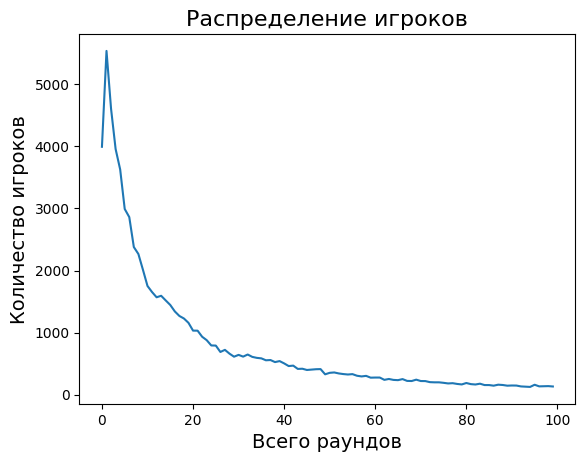

In [ ]:
# Определяем количества игроков для каждого количества игровых раундов
plot_data = data.groupby("sum_gamerounds")["userid"].count()

# Строим график распределения игроков
ax = plot_data.head(100).plot()
plt.title("Распределение игроков", size=16)
plt.xlabel("Всего раундов", size=14)
plt.ylabel("Количество игроков", size=14)
plt.show();

Определяем какой процент игроков установили игру, но не закончили ни один раунд:

In [ ]:
print(round(data[data["sum_gamerounds"]== 0]["userid"].count()/data["userid"].count()*100,2),'%')

4.43 %


Определяем дневной и недельный проценты удержания:

In [ ]:
data_retention = data[["retention_1","retention_7"]].mean()*100
print(f"Дневное удержание: {round(data_retention[0],2)}% \
      \nНедельное удержание: {round(data_retention[1],2)}%")

Дневное удержание: 44.52%       
Недельное удержание: 18.61%


Рассчитаем удержания и количества сыгранных раундов для каждой группы:

In [ ]:
data_retention_ab = data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
data_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


**Разница между группами очень мала, но наблюдается отрицательная динамика тестовой группы относительно контрольной по всем трём метрикам.**

Более подробно поработаем со статистическими показателями.

In [15]:
def statistic_result(control: pd.DataFrame,
                      test_g: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Вероятность событий
    size = control.loc[:, column].shape[0]
    prop_control = control.loc[:, column].sum() / size
    prop_test_g = test_g.loc[:, column].sum() / size

    # bootstrap
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = stats.bernoulli.rvs(p=prop_control, size=size)
        test_g_sample = stats.bernoulli.rvs(p=prop_test_g, size=size)
        booted_diff.append(np.mean(control_sample - test_g_sample))

    # Считаем статистику после bootstrap
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))

    # Считаем мощность эксперимента
    effect_size = proportion.proportion_effectsize(prop_control, prop_test_g)

    power = zt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci,
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column])
    return result

In [12]:
control = data[data.version == 'gate_30'].copy(deep=True)
test_g = data[data.version == 'gate_40'].copy(deep=True)

In [16]:
fig = px.histogram(data, x="version",
                   color='retention_1', barmode='group',
                   title='Игрок активен в течение суток после установки.',
                   height=400)
fig.show()

In [17]:
statistic_result(control, test_g, 'retention_1')

100%|██████████| 10000/10000 [00:41<00:00, 240.37it/s]


,effect_size,alpha,beta,CI,difference
retention_1,-0.003823,0.566051,0.911819,"[-0.009, 0.005]",-0.001911


Таким образом для дневного удержания:

Ошибка 1 рода alpha=0.57 > p-value 0.05

Ошибка 2 рода beta=0.91 > 0.2 20%

Доверительный интервал включает 0

По метрике retention_1 разница значений статистически незначимая.

**Активность новых игроков в течение суток после установки выше у контрольной группы.**

In [18]:
fig = px.histogram(data, x="version",
                   color='retention_7', barmode='group',
                   title='Игрок активен в течение 7 суток после установки.',
                   height=400)
fig.show()

In [19]:
statistic_result(control, test_g, 'retention_7')

100%|██████████| 10000/10000 [00:31<00:00, 319.70it/s]


,effect_size,alpha,beta,CI,difference
retention_7,0.012776,0.056971,0.519844,"[-0.0, 0.01]",0.004988


Таким образом для недельного удержания:

Ошибка 1 рода alpha=0.57 > p-value 0.05

Ошибка 2 рода beta=0.52 > 0.2 20%

Доверительный интервал включает 0

По метрике retention_7 разница значений статистически незначимая.

**Активность новых игроков в течение 7 суток после установки выше для контрольной группы.**

Построим график, иллюстрирующий среднее количество сыгрынных раундов для обеих групп.

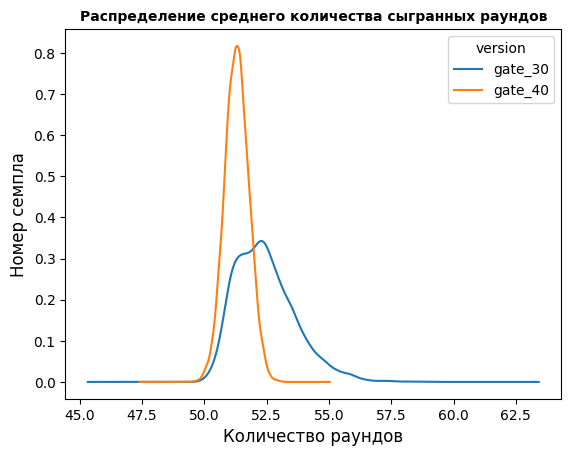

In [22]:
round_sum = []
for i in range(10000):
    mean_round_sum = data.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()
    round_sum.append(mean_round_sum)

round_sum = pd.DataFrame(round_sum)

ax3 = round_sum.plot.kde()
ax3.set_xlabel("Количество раундов",size=12)
ax3.set_ylabel("Номер семпла",size=12)
ax3.set_title("Распределение среднего количества сыгранных раундов", fontweight="bold",size=10)
plt.show()


По графику видно,что среднее количество сыгранных раундов у контрольной групппы также больше.

**Рекомендации  менеджеру.**

Наиболее важные метрики дневного и недельного удержания игроков, а также дополнительная метрика - количество сыгранных раундов, лучше в контрольной группе. Таким образом, обновление игры (перенос ворот на 40 уровень) **не рекомендуется**.

Также рекомендуется провести тест повторно.
